### Iterative Workflow
    repeatedly improving the response from the model based on certain conditions 

Lets take a real-life example -> 
    A content creater working on the making video realted to ai -> but is limited to YouTube b/c -> huge workload to handle on youtube itself -> can't manage making contents for other platform like 'Twitter', 'Insta', 'linkedIn'

Now what we have to make is a agentic system which will generate a content for all these

    Now a problem here is the quality of the system response generated -> so to ensure the quality is good -> we use iterative approach 

![](img/iterative_workflow.png)


make the state -> TweetState 
                topic, tweet, evaluation (literal), feedback, iteration, max_iteration

            three funcitons -> generate_tweet ,evaluate_tweet, optimize_tweet

            for generate_tweet -> messages = [
                SystemMessage(content= "You are a funny and clever Twitter/ influencer. "),
                HumanMessage (content=f"""
                Write a short, original, and hilarious tweet on the topic: "{state['topic'] 1)".
                Rules:
                - Do NOT use question-answer format.
                - Max 280 characters.
                Use observational humor, irony, sarcasm, or cultural references.
                - Think in meme logic, punchlines, or relatable takes.
                - Use simple, day to day english
                - This is version {state['iteration' ] + 1}.
                "'"")

            for evaluate_tweet -> messages = [
                SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor,
                originality, virality, and tweet format."),
                HumanMessage(content=f"'"'"
                Evaluate the following tweet:
                Tweet: "{state['tweet']}"
                Use the criteria below to evaluate the tweet:
                1. Originality - Is this fresh, or have you seen it a hundred times before?
                2. Humor - Did it genuinely make you smile, laugh, or chuckle?
                3. Punchiness - Is it short, sharp, and scroll-stopping?
                4. Virality Potential - Would people retweet or share it?
                5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?
                Auto-reject if:
                - It's written in question-answer format (e.g., "Why did..." or "What happens when..")
                - It exceeds 280 characters
                - It reads like a traditional setup-punchline joke
                - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpieces of the auntie-uncle universe" or vague summaries)
                ### Respond ONLY in structured format:
                - evaluation: "approved" or "needs_improvement"
                - feedback: One paragraph explaining the strengths and weaknesses "'")
                ]

for structured output ->
    from pydantic import BaseModel, Field class TweetEvaluation(BaseModel):
    evaluation: Literal["approved","needs_improvement"] = Field(.., description="Final evaluation result.")
    feedback: str = Field.., description="Constructive feedback for the tweet. ")
    score: int = Field(..•, ge=0, le=5, description="Total score from rubric (0 to 5).") 

            for optimize_tweet -> messages = [
                SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
                HumanMessage(content=f"""
                Improve the tweet based on this feedback:
                "{state[' feedback' ]}"
                Topic: "{state['topic']}"
                Original Tweet:
                {state[ 'tweet' ]}
                Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.


build a conditinal function to choose when to stop and set approved ->
    1. when the evaluator -> approved or the max_iteration are meet

In [24]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Literal, Annotated
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field

In [25]:
load_dotenv()

True

In [89]:
model = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash-lite"
)

In [90]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved", "need_improvement"]
    feedback: str 
    iteration: int
    max_iteration: int

In [91]:
# for strucutred output 
class TweetEvaluation(BaseModel):
    evaluation: Literal['approved', 'need_improvement']= Field(..., description="Final evaluation result")
    feedback: str = Field(..., description="Feedback for the tweet")

In [92]:
structured_model = model.with_structured_output(TweetEvaluation)

In [93]:
def generate_tweet(state: TweetState):
    message = [
        SystemMessage(content= "You are a funny and clever Twitter/ influencer. "),
        HumanMessage(content=f"""
                Write a short, original, and hilarious tweet on the topic: "{state['topic']}".
                Rules:
                - Do NOT use question-answer format.
                - Max 280 characters.
                Use observational humor, irony, sarcasm, or cultural references.
                - Think in meme logic, punchlines, or relatable takes.
                - Use simple, day to day english
                """)
        ]
    response = model.invoke(message).content
    return {
        'tweet':response
    }

def evaluate_tweet(state: TweetState):
    message = [
            SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
            HumanMessage(content=f"""
                Evaluate the following tweet:
                Tweet: "{state['tweet']}"
                Use the criteria below to evaluate the tweet:
                1. Originality - Is this fresh, or have you seen it a hundred times before?
                2. Humor - Did it genuinely make you smile, laugh, or chuckle?
                3. Punchiness - Is it short, sharp, and scroll-stopping?
                4. Virality Potential - Would people retweet or share it?
                5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?
                Auto-reject if:
                - It's written in question-answer format (e.g., "Why did..." or "What happens when..")
                - It exceeds 280 characters
                - It reads like a traditional setup-punchline joke
                - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpieces of the auntie-uncle universe" or vague summaries)
                ### Respond ONLY in structured format:
                - evaluation: "approved" or "needs_improvement"
                - feedback: One paragraph explaining the strengths and weaknesses """)
            ]
    response = structured_model.invoke(message)
    return {
        'evaluation': response.evaluation,
        'feedback': response.feedback
    }

def optimize_tweet(state: TweetState):
    message = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
            Improve the tweet based on this feedback: "{state['feedback']}"
            Topic: "{state['topic']}"
            Original Tweet: "{state['tweet']}"
            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
            """)
    ]
    response = model.invoke(message).content
    iteration = state['iteration'] + 1
    return {
        'tweet': response,
        'iteration': iteration
    }

# for conditional graph edges
def route_evaluation(state: TweetState):
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'need_improvement'


In [94]:
# define the state
graph = StateGraph(TweetState)

# add nodes
graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

# add edges
graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'need_imporvement': 'optimize'})

graph.add_edge('optimize', 'evaluate')

# compile the graph
workflow = graph.compile()

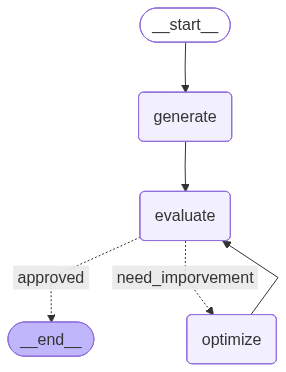

In [95]:
workflow

In [96]:
initial_state = {
    "topic":'Indian Railways',
    "iteration": 1,
    "max_iteration":5
}

final_state = workflow.invoke(initial_state)
print(final_state)

{'topic': 'Indian Railways', 'tweet': 'Just booked a train ticket in India. Pretty sure the "estimated arrival time" is a suggestion, like "eat your vegetables." 😅 My luggage is already mentally preparing for a spontaneous world tour. #IndianRailways #AdventureTime', 'evaluation': 'approved', 'feedback': "This tweet hits the mark with its relatable humor about Indian train travel. The comparison of estimated arrival times to 'eat your vegetables' is original and funny, and the image of luggage preparing for a 'spontaneous world tour' adds a great visual gag. It's concise, under the character limit, and uses relevant hashtags effectively. The humor feels genuine and has good potential for retweets among those familiar with the experience.", 'iteration': 1, 'max_iteration': 5}
